In [14]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
def save_as_csv(data_array, file_name="data"):
    """
        Create .csv file with given name from given NumPy data array
        in the current directory.
        
        Args:
            data_array: NumPy structures data array
            file_name: name of .csv file to be created
            
        Returns:
            Nothing but creates a file in the current directory.
    """
    output_name = file_name + ".csv"
    np.savetxt(output_name, data_array, delimiter=",", fmt='%-7.4f', 
               header=str(data_array.dtype.names).replace('(',"").replace(')',"").replace("#", "") + " ",
              comments='')
    
def apply_wt_once(data, wavelet='haar', level=2, mode='constant'):
    """
    This function performs a WT on data and keeps only the low 
    frequencies in the decomposition.
    The original paper refers to this time-series as S_J(t).
    
    Args:
        data: the univariate to apply the wavelet transform
        wavelet: the type of wavelet transform
        level: level of WT
        mode: how the WT is applied on the ends of the datasets
        
    Return:
        reconstructed time-series from WT decomposition where the 
        high-frequency entries have been ignored
    """
    haar_dwt = pywt.wavedec(data, wavelet=wavelet, level=level, mode=mode)
    
    # delete the high frequencies from the decomposition
    haar_dwt[1] = np.zeros_like(haar_dwt[1])
    haar_dwt[2] = np.zeros_like(haar_dwt[2])
  
    return pywt.waverec(haar_dwt, mode=mode, wavelet=wavelet)

def apply_wt_twice(data, wavelet='haar', level=2, mode='constant'):
    """
        This function applies the WT twice, each time ignoring the high-frequency terms.
        
        Args:
            data: univariate data to apply the WT twice on.
            wavelet: type of WT
            level: level of WT
            mode: mode used to compute WT on the edges
        
        Return:
            Reconstructed time-series ignoring the higher frequencies.
    """
    wt_results = apply_wt_once(data=data,
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)
    
    return apply_wt_once(data=wt_results,
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)

def get_accuracy(data1, data2):
    """
        This function computes the standard error between two np.arrays data1 and data2 of same size.
        
        Args:
            data1: 1-d np.array
            datat2: 1-d np.array
            
        Returns:
            standard deviation of the difference data1-data2.
            
    """

    return np.std(data1-data2)

def apply_wt_twice_on_dataset(dataset, wavelet='haar', level=2, mode='constant'):
    """
        This function applies the WT of selected type, level and mode
        twice on each columns of the data, ignoring the first two columns
        (Ntime and time).
        
        Args:
            dataset: structured np.array
            wavelet: type of wavelet
            level: number of levels for the WT
            mode: mode of WT to deal with both ends of the data
            
        Return:
            A dataset with same number of columns as the original 
            but which have been applied the WT twice. Note that
            columns named 'Ntime' and 'time' are not
    """
    ignored_col_names = ('Ntime', 'time', 'Time') # from the SP500 dataset, might need some tweaking
    col_names = dataset.dtype.names

    results = np.zeros_like(dataset)
    results[ignored_col_names[0]] = dataset[ignored_col_names[0]]
    if ignored_col_names[1] in dataset.dtype.names:
        results[ignored_col_names[1]] = dataset[ignored_col_names[1]]
    else:
        results[ignored_col_names[2]] = dataset[col_names[1]]
    
    for name in col_names:
        if name not in ignored_col_names:
            temp = apply_wt_twice(
                                dataset[name],
                                wavelet=wavelet,
                                level=level,
                                mode=mode
                                 )
            results[name] = temp[:len(dataset[name])]
        
    return results
 

def end_to_end_twice_wt_with_csv(input_file_name, output_file_name, wavelet='haar', level=2, mode='constant'):
    """
        This functions applies a two-level WT twice, keeping the lowest frequency signal between the first and second
        WT application (given the mode, wavelet type and level). 
        Note: It saves the result in data/data_wt/output_file_name.csv
        
        Args:
            input_file_name: .csv in which the original dataset is saved.
            output_file_name: name of the output .csv file
            wavelet: type of wavelet (default: Haar wavelet)
            level: number of level in each WT
            mode: methods of signal extrapolation that can be used to minimize 
                  the negative effect of scarce data at both ends of the dataset
                  
        Returns:
            np.array with output of the double n-level WT
    """
    data_array = np.genfromtxt('data/' + input_file_name, delimiter=',', dtype=float, names=True)
    res = apply_wt_twice_on_dataset(data_array,
                                wavelet=wavelet,
                                level=level,
                                mode=mode)
    save_as_csv(res, file_name="data/data_wt/" + output_file_name)
    res = [list(x) for x in res]
    return np.array(res)


In [28]:
# Definining variables for WT
current_level = 2
current_mode = 'constant'
current_wavelet = pywt.Wavelet('haar')

end_to_end_twice_wt_with_csv("sp500_index_data.csv", "sp500_wt")
# end_to_end_twice_wt_with_csv("sp500_index_data.csv", "sp500_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)


# Still an issue with the variable names for some of the following datasets:

# end_to_end_twice_wt_with_csv("nikkei_225_index_data.csv", "nikkei_225_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)
# end_to_end_twice_wt_with_csv("nifty_50_index_data.csv", "nifty_50_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)
# end_to_end_twice_wt_with_csv("hangseng_index_data.csv", "hangseng_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)
# end_to_end_twice_wt_with_csv("djia_index_data.csv", "djia_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)
# end_to_end_twice_wt_with_csv("csi300_index_data.csv", "csi300_wt", wavelet=current_wavelet,
#                    level=current_level, mode=current_mode)
#testing = np.genfromtxt('sp500_wt.csv', delimiter=',', dtype=float, names=True)



(2079, 21)


('Ntime', 'time', 'Close_Price', 'Open_Price', 'High_Price', 'Low_Price', 'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5', 'MTM12', 'ROC', 'SMI', 'WVAD', 'US_Dollar_Index', 'Federal_Fund_Rate')


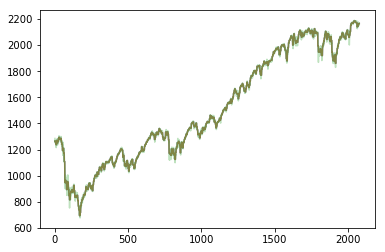

accuracy: 13.351546004542405


In [18]:
sp500_data = np.genfromtxt('data/sp500_index_data.csv', delimiter=',', dtype=float, names=True)
print(sp500_data.dtype.names) # print names of columns



# Assessing difference in the multiple level procedure
once_wt = apply_wt_once(data=sp500_data['Close_Price'],
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)

twice_wt = apply_wt_twice(data=sp500_data['Close_Price'],
                        wavelet=current_wavelet,
                        level=current_level,
                        mode=current_mode)

plt.plot(twice_wt)
plt.plot(once_wt, alpha=0.6)
plt.plot(sp500_data['Close_Price'], alpha=.3)
plt.show()

print("accuracy: {}".format(get_accuracy(twice_wt[:-1], sp500_data['Close_Price'])))
# the WT adds one points, hence why we have to ignore the last or first points of the resulting vector

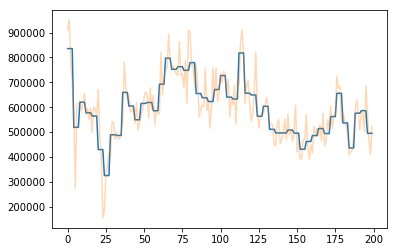

In [19]:
# TOY EXAMPLE

# Applying this on the SP500 dataset:
res = apply_wt_twice_on_dataset(sp500_data,
                                wavelet=current_wavelet,
                                level=current_level,
                                mode=current_mode)

plt.plot(res["Volume"][100:300])
plt.plot(sp500_data["Volume"][100:300], alpha=0.3)
plt.show()